In [4]:
pip install scikit-spatial

  Using cached scikit_spatial-8.0.0-py3-none-any.whl (49 kB)

[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: /Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from skspatial.objects import LineSegment, Line, Vector

# some helper functions
from helpers import (
    get_arc_point,
    draw_arc,
    rotate,
    translate,
    flip_y,
    flip_x,
    optimize_points,
    chaikin,
    rotate_point,
    scale,
)
from pcb_json import (
    dump_json,
    plot_json,
    create_via,
    create_pad,
    create_pin,
    create_track,
    create_silk,
    create_silk,
    create_mounting_hole,
)

from enum import Enum

Layer = Enum("Layer", "FRONT BACK")

In [2]:
# Track width and spacing
TRACK_WIDTH = 0.127
TRACK_SPACING = 0.127

# via defaults
VIA_DIAM = 0.8
VIA_DRILL = 0.4

# this is for a 1.27mm pitch pin
PIN_DIAM = 1.0
PIN_DRILL = 0.65

# this is for the PCB connector - see https://www.farnell.com/datasheets/2003059.pdf
PAD_WIDTH = 3
PAD_HEIGHT = 2
PAD_PITCH = 2.5

STATOR_HOLE_RADIUS = 5.5
HOLE_SPACING = 0.25

# Coils net name
COIL_NET_NAME = "coils"

In [3]:
# Standard 25 mm version

# PCB Edge size
STATOR_RADIUS = 25
STATOR_HOLE_RADIUS = 5.5

# where to puth the mounting pins
SCREW_HOLE_DRILL_DIAM = 2.3  # 2.3mm drill for a 2mm screw
SCREW_HOLE_RADIUS = STATOR_RADIUS

# Coil params
TURNS = 12
COIL_CENTER_RADIUS = 16
COIL_VIA_RADIUS = 17

In [4]:
# Large 30 mm version

# PCB Edge size
STATOR_RADIUS = 30

# where to puth the mounting pins
SCREW_HOLE_DRILL_DIAM = 2.3  # 2.3mm drill for a 2mm screw
SCREW_HOLE_RADIUS = STATOR_RADIUS

# Coil params
TURNS = 16
COIL_CENTER_RADIUS = 19.95
COIL_VIA_RADIUS = 20.95

In [5]:
# where to put the input pads
INPUT_PAD_RADIUS = STATOR_RADIUS - (PAD_WIDTH / 2 + VIA_DIAM + TRACK_SPACING)

USE_SPIRAL = False

LAYERS = 4

# Radial coil generator

In [6]:
def get_points(spacing, inner_radius, outer_radius, start_angle, end_angle):
    # first calculate the angle step size from the spacing and the inner_radius
    spacing_angle = np.rad2deg(np.arctan2(spacing, inner_radius))
    print(spacing_angle)
    # now calculate the points be iterating from start_angle to end_angle with the spacing_angle
    points = []
    for angle in np.arange(start_angle, end_angle, spacing_angle * 2):
        points.append(get_arc_point(angle, inner_radius))
        points.append(get_arc_point(angle, outer_radius))
        points.append(
            (
                get_arc_point(angle, outer_radius)[0],
                get_arc_point(angle, outer_radius)[1] + spacing,
            )
        )
        points.append(get_arc_point(angle + spacing_angle, inner_radius))
    return points

1.4623083416886962
Total length front 445.35088794554304


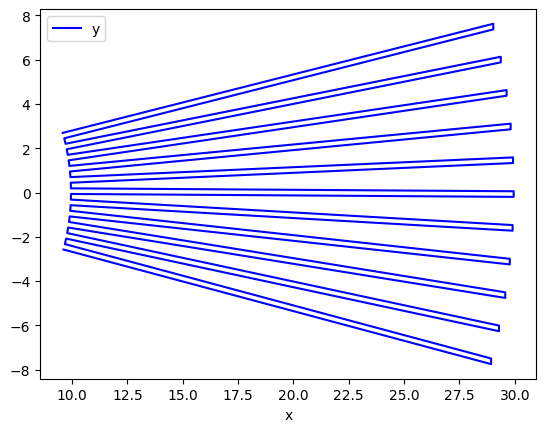

In [7]:
points_f = get_points(
    TRACK_SPACING + TRACK_WIDTH,
    (COIL_CENTER_RADIUS - 10),
    COIL_CENTER_RADIUS + 10,
    -15,
    15,
)

df = pd.DataFrame(points_f, columns=["x", "y"])
ax = df.plot.line(x="x", y="y", color="blue")
ax.axis("equal")

# calculat the total length of the track to compute the resistance
total_length_front = 0
for i in range(len(points_f) - 1):
    total_length_front += np.linalg.norm(
        np.array(points_f[i + 1]) - np.array(points_f[i])
    )
print("Total length front", total_length_front)

In [8]:
spacing = TRACK_SPACING + TRACK_WIDTH
inner_radius = COIL_CENTER_RADIUS - 10
outer_radius = COIL_CENTER_RADIUS + 10
start_angle = -15
end_angle = 15
# first calculate the angle step size from the spacing and the inner_radius
spacing_angle = np.rad2deg(np.arctan2(spacing, inner_radius))
# now calculate the points be iterating from start_angle to end_angle with the spacing_angle
i = 0
count = (end_angle - start_angle) // spacing_angle
print(spacing_angle, count)
# for angle in np.arange(start_angle, end_angle, spacing_angle):
for angle in [start_angle, end_angle]:
    i = i + 1
    current = 1
    if i == 2:
        current = -1
    with open(f"simulations/radial_{i}.csv", "w") as f:
        points = [
            get_arc_point(angle, inner_radius),
            get_arc_point(angle, outer_radius),
        ]
        points = translate(rotate(points, 90), -22.5, 90)
        for point in points:
            f.write(f"{point[0]}/10,{point[1]}/10,0,{current}\n")


# # write the coil out in a format that can be simulated
p_f = translate(rotate(points_f, 90), -22.5, 90)
p_b = translate(rotate(points_f, 90), -22.5, 90)

# df = pd.DataFrame(p_f, columns=["x", "y"])
# ax = df.plot.line(x="x", y="y", color="blue")
# ax.axis("equal")

with open("simulations/coils/coil_rad.csv", "w") as f:
    for point in p_f:
        f.write(f"{point[0]},{point[1]},0,0.5\n")

# two layer board
with open("simulations/coils/coil-rad-2-layer.csv", "wt") as f:
    for point in p_f:
        f.write(f"{point[0]},{point[1]},0,0.5\n")
    for point in p_b:
        f.write(f"{point[0]},{point[1]},{0-0.062},0.5\n")

# all four layer board
with open("simulations/coils/coil-rad-4-layer.csv", "wt") as f:
    for point in p_f:
        f.write(f"{point[0]},{point[1]},0,0.5\n")
    for point in p_b:
        f.write(f"{point[0]},{point[1]},{0-0.011},0.5\n")
    for point in p_f:
        f.write(f"{point[0]},{point[1]},{0-(0.011+0.04)},0.5\n")
    for point in p_b:
        f.write(f"{point[0]},{point[1]},{0-(0.011+0.011+0.04)},0.5\n")

1.4623083416886962 20.0


# Generate PCB Layout

In [10]:
# calculat the total length of the track to compute the resistance
total_length_front = 0
for i in range(len(points_f) - 1):
    total_length_front += np.linalg.norm(
        np.array(points_f[i + 1]) - np.array(points_f[i])
    )
print("Total length front", total_length_front)

points_b = points_f
total_length_back = 0
for i in range(len(points_b) - 1):
    total_length_back += np.linalg.norm(
        np.array(points_b[i + 1]) - np.array(points_b[i])
    )
print("Total length back", total_length_back)

Total length front 445.35088794554304
Total length back 445.35088794554304


In [21]:
vias = []
tracks_f = []
tracks_b = []
pads = []
pins = []
mounting_holes = []
silk = []


# shift the coils aronnd to make connections a bit easier
COIL_ROTATION = -360 / 12

coil_angles = []
for i in range(12):
    angle = i * 360 / 12 + COIL_ROTATION
    coil_angles.append(angle)

# the main coils
coil_labels = ["A", "B", "C"]
coils_f = []
coils_b = []
for i in range(12):
    angle = coil_angles[i]
    if (i // 3) % 2 == 0:
        coil_A_f = translate(rotate(points_f, angle), COIL_CENTER_RADIUS, angle)
        coil_A_b = translate(rotate(points_b, angle), COIL_CENTER_RADIUS, angle)
    else:
        # slightly nudge the coils so that they don't overlap when flipped
        coil_A_f = translate(rotate(flip_y(points_f), angle), COIL_CENTER_RADIUS, angle)
        coil_A_b = translate(rotate(flip_y(points_b), angle), COIL_CENTER_RADIUS, angle)
    # keep track of the coils
    coils_f.append(coil_A_f)
    coils_b.append(coil_A_b)

    tracks_f.append(coil_A_f)
    tracks_b.append(coil_A_b)
    vias.append(create_via(get_arc_point(angle, COIL_VIA_RADIUS), COIL_NET_NAME))
    silk.append(
        create_silk(get_arc_point(angle, COIL_CENTER_RADIUS), coil_labels[i % 3], COIL_NET_NAME)
    )

# raidus for connecting the bottoms of the coils together
connection_radius1 = STATOR_HOLE_RADIUS + 3 * TRACK_SPACING

# create tracks to link the A coils around the center
connection_via_radius_A = connection_radius1 + 3 * TRACK_SPACING + VIA_DIAM / 2
coil_A1_A2_inner = (
    [get_arc_point(coil_angles[0], connection_via_radius_A)]
    + draw_arc(COIL_ROTATION, coil_angles[3], connection_radius1)
    + [get_arc_point(coil_angles[3], connection_via_radius_A)]
)
tracks_f.append(coil_A1_A2_inner)
coil_A3_A4_inner = (
    [get_arc_point(coil_angles[6], connection_via_radius_A)]
    + draw_arc(coil_angles[6], coil_angles[9], connection_radius1)
    + [get_arc_point(coil_angles[9], connection_via_radius_A)]
)
tracks_f.append(coil_A3_A4_inner)
# connect up the bottoms of the A coils
coils_b[0].append(coil_A1_A2_inner[0])
coils_b[3].append(coil_A1_A2_inner[-1])
coils_b[6].append(coil_A3_A4_inner[0])
coils_b[9].append(coil_A3_A4_inner[-1])
# add the vias to stitch them together
vias.append(create_via(coil_A1_A2_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_A1_A2_inner[-1], COIL_NET_NAME))
vias.append(create_via(coil_A3_A4_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_A3_A4_inner[-1], COIL_NET_NAME))

# create tracks to link the B coils around the center - this can all be done on the bottom layer
coil_B1_B2_inner = draw_arc(coil_angles[1], coil_angles[4], connection_radius1)
tracks_b.append(coil_B1_B2_inner)
coil_B3_B4_inner = draw_arc(coil_angles[7], coil_angles[10], connection_radius1)
tracks_b.append(coil_B3_B4_inner)
# connect up the bottoms of the A coils
coils_b[1].append(coil_B1_B2_inner[0])
coils_b[4].append(coil_B1_B2_inner[-1])
coils_b[7].append(coil_B3_B4_inner[0])
coils_b[10].append(coil_B3_B4_inner[-1])

# create tracks to link the C coils around the center
connection_via_radius_C = connection_via_radius_A + 3 * TRACK_SPACING + VIA_DIAM / 2
coil_C1_C2_inner = draw_arc(coil_angles[2], coil_angles[5], connection_via_radius_C)
tracks_f.append(coil_C1_C2_inner)
coil_C3_C4_inner = draw_arc(coil_angles[8], coil_angles[11], connection_via_radius_C)
tracks_f.append(coil_C3_C4_inner)
# connect up the bottoms of the B coils
coils_b[2].append(coil_C1_C2_inner[0])
coils_b[5].append(coil_C1_C2_inner[-1])
coils_b[8].append(coil_C3_C4_inner[0])
coils_b[11].append(coil_C3_C4_inner[-1])
# add the vias to stitch them together
vias.append(create_via(coil_C1_C2_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_C1_C2_inner[-1], COIL_NET_NAME))
vias.append(create_via(coil_C3_C4_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_C3_C4_inner[-1], COIL_NET_NAME))

# connect the last three coils together
common_connection_radius = SCREW_HOLE_RADIUS - (SCREW_HOLE_DRILL_DIAM / 2 + 0.5)
tracks_f.append(draw_arc(coil_angles[9], coil_angles[11], common_connection_radius))
coils_f[9].append(get_arc_point(coil_angles[9], common_connection_radius))
coils_f[10].append(get_arc_point(coil_angles[10], common_connection_radius))
coils_f[11].append(get_arc_point(coil_angles[11], common_connection_radius))

# connect the outer A coils together
outer_connection_radius_A = SCREW_HOLE_RADIUS - (SCREW_HOLE_DRILL_DIAM / 2 + 0.5)
tracks_f.append(draw_arc(coil_angles[3], coil_angles[6], outer_connection_radius_A))
coils_f[3].append(get_arc_point(coil_angles[3], outer_connection_radius_A))
coils_f[6].append(get_arc_point(coil_angles[6], outer_connection_radius_A))

# connect the outer B coils together
outer_connection_radius_B = outer_connection_radius_A - TRACK_SPACING - VIA_DIAM / 2
tracks_b.append(
    [get_arc_point(coil_angles[4], outer_connection_radius_B)]
    + draw_arc(coil_angles[4], coil_angles[7], outer_connection_radius_A)
    + [get_arc_point(coil_angles[7], outer_connection_radius_B)]
)
coils_f[4].append(get_arc_point(coil_angles[4], outer_connection_radius_B))
coils_f[7].append(get_arc_point(coil_angles[7], outer_connection_radius_B))
vias.append(
    create_via(get_arc_point(4 * 360 / 12 + COIL_ROTATION, outer_connection_radius_B), COIL_NET_NAME)
)
vias.append(
    create_via(get_arc_point(7 * 360 / 12 + COIL_ROTATION, outer_connection_radius_B), COIL_NET_NAME)
)

# connect the outer C coils together
outer_connection_radius_C = outer_connection_radius_B - TRACK_SPACING - VIA_DIAM / 2
tracks_b.append(
    draw_arc(
        5 * 360 / 12 + COIL_ROTATION,
        8 * 360 / 12 + COIL_ROTATION,
        outer_connection_radius_C,
    )
)
coils_f[5].append(
    get_arc_point(5 * 360 / 12 + COIL_ROTATION, outer_connection_radius_C)
)
coils_f[8].append(
    get_arc_point(8 * 360 / 12 + COIL_ROTATION, outer_connection_radius_C)
)
vias.append(
    create_via(get_arc_point(5 * 360 / 12 + COIL_ROTATION, outer_connection_radius_C), COIL_NET_NAME)
)
vias.append(
    create_via(get_arc_point(8 * 360 / 12 + COIL_ROTATION, outer_connection_radius_C), COIL_NET_NAME)
)

#  create the pads for connecting the inputs to the coils
silk.append(
    create_silk((INPUT_PAD_RADIUS - PAD_HEIGHT - 2.5, PAD_PITCH), "C", "b", 2.5, -900)
)
silk.append(create_silk((INPUT_PAD_RADIUS - PAD_HEIGHT - 2.5, 0), "B", "b", 2.5, -900))
silk.append(
    create_silk((INPUT_PAD_RADIUS - PAD_HEIGHT - 2.5, -PAD_PITCH), "A", "b", 2.5, -900)
)

pads.append(create_pad((INPUT_PAD_RADIUS, -PAD_PITCH), PAD_WIDTH, PAD_HEIGHT, "b", COIL_NET_NAME))
pads.append(create_pad((INPUT_PAD_RADIUS, 0), PAD_WIDTH, PAD_HEIGHT, "b", COIL_NET_NAME))
pads.append(create_pad((INPUT_PAD_RADIUS, PAD_PITCH), PAD_WIDTH, PAD_HEIGHT, "b", COIL_NET_NAME))

# connect coil A to the top pad
pad_connection_point_x = INPUT_PAD_RADIUS
pad_angle = np.rad2deg(np.arcsin(PAD_PITCH / pad_connection_point_x))
coils_f[0].append(get_arc_point(coil_angles[0], pad_connection_point_x))
vias.append(create_via(get_arc_point(coil_angles[0], pad_connection_point_x), COIL_NET_NAME))
# connect coil B to the middle pad
coils_f[1].append((pad_connection_point_x + PAD_WIDTH / 2 + VIA_DIAM / 2, 0, COIL_NET_NAME))
vias.append(create_via(((pad_connection_point_x + PAD_WIDTH / 2 + VIA_DIAM / 2, 0)), COIL_NET_NAME))
# connect coil C to the bottom pad
coils_f[2].append(get_arc_point(coil_angles[2], pad_connection_point_x))
vias.append(create_via(get_arc_point(coil_angles[2], pad_connection_point_x), COIL_NET_NAME))

In [22]:
# if we are doing four layers then duplicate the front and back layers on (front and inner1), (inner2 and back)
tracks_in1 = []
tracks_in2 = []
if LAYERS == 4:
    tracks_in1 = tracks_b.copy()
    tracks_in2 = tracks_f.copy()

# these final bits of wiring up to the input pads don't need to be duplicated
tracks_b.append(
    [(pad_connection_point_x + PAD_WIDTH / 2, 0), (pad_connection_point_x, 0)]
)
tracks_b.append(draw_arc(coil_angles[0], -pad_angle, pad_connection_point_x, 1))
tracks_b.append(draw_arc(coil_angles[2], pad_angle, pad_connection_point_x, 1))

nibble_angle_size = 360 * SCREW_HOLE_DRILL_DIAM / (2 * np.pi * STATOR_RADIUS)

outer_cuts = (
    draw_arc(-45 + nibble_angle_size / 2, 45 - nibble_angle_size / 2, STATOR_RADIUS, 5)
    + translate(
        rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5)[::-1], 135),
        STATOR_RADIUS,
        45,
    )
    + draw_arc(
        45 + nibble_angle_size / 2, 135 - nibble_angle_size / 2, STATOR_RADIUS, 5
    )
    + translate(
        rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5), 225)[::-1],
        STATOR_RADIUS,
        135,
    )
    + draw_arc(
        135 + nibble_angle_size / 2, 225 - nibble_angle_size / 2, STATOR_RADIUS, 5
    )
    + translate(
        rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5), 315)[::-1],
        STATOR_RADIUS,
        225,
    )
    + draw_arc(
        225 + nibble_angle_size / 2, 315 - nibble_angle_size / 2, STATOR_RADIUS, 5
    )
    + translate(
        rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5), 45)[::-1],
        STATOR_RADIUS,
        315,
    )
)

edge_cuts = [
    outer_cuts,
    draw_arc(0, 360, STATOR_HOLE_RADIUS, 1),
]

# dump out the json version
json_result = dump_json(
    filename=f"coils_12_{STATOR_RADIUS}mm.json",
    track_width=TRACK_WIDTH,
    pin_diam=PIN_DIAM,
    pin_drill=PIN_DRILL,
    via_diam=VIA_DIAM,
    via_drill=VIA_DRILL,
    vias=vias,
    pins=pins,
    pads=pads,
    silk=silk,
    tracks_f=tracks_f,
    tracks_in1=tracks_in1,
    tracks_in2=tracks_in2,
    tracks_b=tracks_b,
    mounting_holes=mounting_holes,
    edge_cuts=edge_cuts,
)

TypeError: dump_json() got an unexpected keyword argument 'tracks_in1'

In [ ]:
# plot the json
plot_json(json_result)